C:\Users\DELL\AppData\Local\Temp\ipykernel_10712\3740326170.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


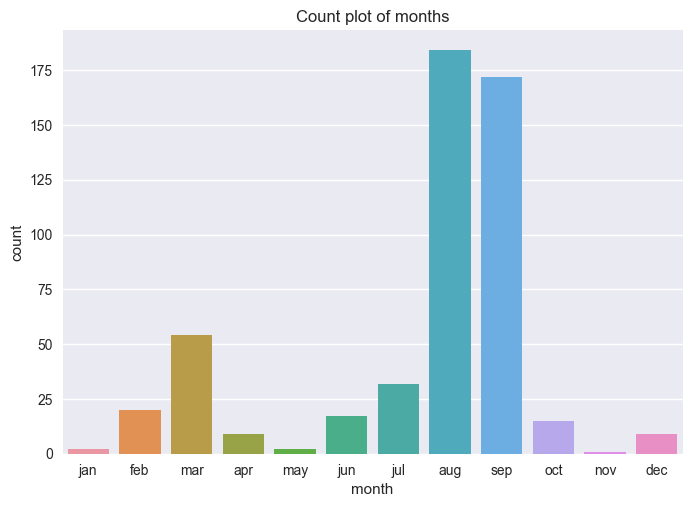

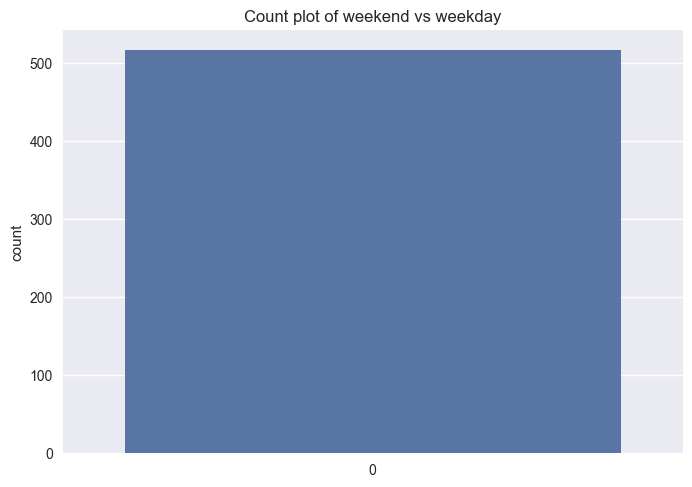

R^2 score: -0.027940245513741635
Predicted area: [0.46769513]


C:\Program Files\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import pickle
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

# Read the dataset
df = pd.read_csv('forestfires.csv')

# Create the size_category column based on the area
df['size_category'] = np.where(df['area'] > 6, '1', '0')
df['size_category'] = pd.to_numeric(df['size_category'])

# Convert month to categorical and visualize data
df['month'] = pd.Categorical(df['month'], categories=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])
sns.countplot(x='month', data=df)
plt.title('Count plot of months')
plt.show()

# Dictionary of months mapping to seasons
season_dict = {'dec': 'winter', 'jan': 'winter', 'feb': 'winter',
               'mar': 'spring', 'apr': 'spring', 'may': 'spring',
               'jun': 'summer', 'jul': 'summer', 'aug': 'summer', 'sep': 'summer',
               'oct': 'autumn', 'nov': 'autumn'}

# Create the season column based on the month column
df['season'] = df['month'].map(season_dict)

# Convert season to binary (is_summer)
df['season'] = (df['season'] == 'summer')

# Convert day to binary (is_weekend)
df['day'] = ((df['day'] == 'sun') | (df['day'] == 'sat') | (df['day'] == 'fri'))

# Plot count of weekend vs weekday
sns.countplot(df['day'])
plt.title('Count plot of weekend vs weekday')
plt.show()

# Apply natural logarithm scaling to rain and area
df.loc[:, ['rain', 'area']] = df.loc[:, ['rain', 'area']].apply(lambda x: np.log(x + 1), axis=1)

# Prepare features and labels
features = df.drop(columns=['area', 'size_category'])
labels = df['area']

# Define the numeric columns and categorical columns
numeric_columns = ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
categorical_columns = ['month', 'day', 'season']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Create a pipeline for preprocessing
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(sparse=False, handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

# Create the model
model = LinearRegression()

# Create the pipeline with preprocessing and modeling
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Evaluate the model
score = pipeline.score(X_test, y_test)
print("R^2 score:", score)
# Save the trained model
filename = 'fire_model.pkl'
pickle.dump(model, open(filename, 'wb'))

# Load the trained model
loaded_model = pickle.load(open(filename, 'rb'))

# Example new input data
new_input = pd.DataFrame({
    'X': [1],
    'Y': [2],
    'month': ['sep'],
    'day': ['fri'],
    'FFMC': [85.5],
    'DMC': [42.2],
    'DC': [770.3],
    'ISI': [13.6],
    'temp': [15.5],
    'RH': [42],
    'wind': [3.1],
    'rain': [0.0],
    'season': ['summer']
})

# Preprocess the new input data
new_input_preprocessed = pipeline.named_steps['preprocessor'].transform(new_input)

# Make predictions
prediction = pipeline.named_steps['model'].predict(new_input_preprocessed)

print("Predicted area:", prediction)